# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  

**Целевой признак**  
Price — цена (евро)  

**Примечания:**  
- Для оценки качества моделей применяйте метрику RMSE. 
- Значение метрики RMSE должно быть меньше 2500.  
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.  
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.  
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.  

## Подготовка данных

**Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.**  
**Подготовьте выборки для обучения моделей.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

from catboost import Pool, CatBoostRegressor, cv

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

У нас есть и численные и категориальные признаки. Также есть столбцы, которые можно удалить - DateCrawled, LastSeen, DateCreated, PostalCode, NumberOfPictures, RegistrationMonth - так как они не влияют на конечную цену машины.  
Также есть пропущенные данные, надо понять можно ли их удалить или как-то попробовать заполнить. 

In [5]:
sorted_data = data[['VehicleType', 
                'Gearbox', 
                'Power',
                'Kilometer',
                'FuelType',
                'Brand',
                'Repaired',
                'RegistrationYear',
                'Model',
                'Price']]
display(sorted_data)

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model,Price
0,NaN,manual,0,150000,petrol,volkswagen,NaN,1993,golf,480
1,coupe,manual,190,125000,gasoline,audi,yes,2011,NaN,18300
2,suv,auto,163,125000,gasoline,jeep,NaN,2004,grand,9800
3,small,manual,75,150000,petrol,volkswagen,no,2001,golf,1500
4,small,manual,69,90000,gasoline,skoda,no,2008,fabia,3600
...,...,...,...,...,...,...,...,...,...,...
354364,NaN,manual,0,150000,petrol,mitsubishi,yes,2005,colt,0
354365,NaN,NaN,0,20000,NaN,sonstige_autos,NaN,2005,NaN,2200
354366,convertible,auto,101,125000,petrol,smart,no,2000,fortwo,1199
354367,bus,manual,102,150000,gasoline,volkswagen,no,1996,transporter,9200


Категориальные признаки можно заполнить значениями, которые чаще всего встречаются в конкретном признаке - это для столбцов: Gearbox, Repaired.  
А у столбца VehicleType(тип автомобильного кузова) пропущенные значения можно заполнить в зависимости от модели автомобиля(Model), либо от марки автомобиля(Brand) - пока не понимаю как правильно!  
Для Model поставим глушилки - unknown, так как тут пропущенные значения никак не подставить.  
FuelType столбец можно заполнить по популярному варианту из столбца Brand.
 

Но сначала проверим есть ли 0 в столбце Price, если есть, то удаляем их.

In [6]:
sorted_data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

In [7]:
sorted_data = sorted_data.query('Price > 1')
sorted_data['Price'].value_counts()

500      5670
1500     5394
1000     4649
1200     4594
2500     4438
         ... 
5240        1
13180       1
10879       1
2683        1
8188        1
Name: Price, Length: 3729, dtype: int64

Далее заменим пропуски в столбцах.

manual    0.801139
auto      0.198861
Name: Gearbox, dtype: float64


<AxesSubplot:>

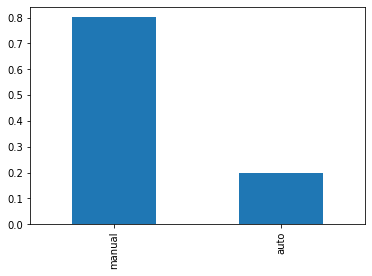

In [8]:
class_gearbox = sorted_data['Gearbox'].value_counts(normalize=True)
print(class_gearbox)
class_gearbox.plot(kind='bar')

no     0.878049
yes    0.121951
Name: Repaired, dtype: float64


<AxesSubplot:>

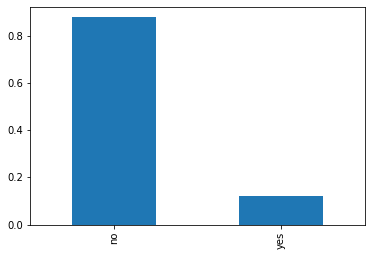

In [9]:
class_repaired = sorted_data['Repaired'].value_counts(normalize=True)
print(class_repaired)
class_repaired.plot(kind='bar')

In [10]:
sorted_data.fillna({'Gearbox':'manual', 
                           'Repaired':'no',
                           'Model':'unknown'},
                          inplace=True)
sorted_data.isna().sum()

VehicleType         33282
Gearbox                 0
Power                   0
Kilometer               0
FuelType            29019
Brand                   0
Repaired                0
RegistrationYear        0
Model                   0
Price                   0
dtype: int64

Дальше пыталась заменить у VehicleType и у FuelType пропущенные значения в зависимости от модели, но как-то не разобралась. Заменила у этих столбцов пропуски просто самыми популярными значениями. 

In [11]:
sorted_data['VehicleType'] = sorted_data['VehicleType'].fillna(sorted_data['VehicleType'].mode().values[0])
sorted_data['FuelType'] = sorted_data['FuelType'].fillna(sorted_data['FuelType'].mode().values[0])

display(sorted_data['VehicleType'].value_counts())
display(sorted_data['FuelType'].value_counts())

sorted_data.isna().sum()

sedan          122490
small           77847
wagon           63552
bus             28283
convertible     19828
coupe           15578
suv             11769
other            3061
Name: VehicleType, dtype: int64

petrol      239223
gasoline     97001
lpg           5155
cng            552
hybrid         226
other          164
electric        87
Name: FuelType, dtype: int64

VehicleType         0
Gearbox             0
Power               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
RegistrationYear    0
Model               0
Price               0
dtype: int64

In [12]:
sorted_data.duplicated().sum()

54118

In [13]:
sorted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342408 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       342408 non-null  object
 1   Gearbox           342408 non-null  object
 2   Power             342408 non-null  int64 
 3   Kilometer         342408 non-null  int64 
 4   FuelType          342408 non-null  object
 5   Brand             342408 non-null  object
 6   Repaired          342408 non-null  object
 7   RegistrationYear  342408 non-null  int64 
 8   Model             342408 non-null  object
 9   Price             342408 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 28.7+ MB


In [14]:
sorted_data = sorted_data.drop_duplicates()
sorted_data.duplicated().sum()

0

In [15]:
sorted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288290 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       288290 non-null  object
 1   Gearbox           288290 non-null  object
 2   Power             288290 non-null  int64 
 3   Kilometer         288290 non-null  int64 
 4   FuelType          288290 non-null  object
 5   Brand             288290 non-null  object
 6   Repaired          288290 non-null  object
 7   RegistrationYear  288290 non-null  int64 
 8   Model             288290 non-null  object
 9   Price             288290 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.2+ MB


Теперь перейдем к аномалиям. 

In [16]:
sorted_data.describe()

,Power,Kilometer,RegistrationYear,Price
count,288290.000000,288290.000000,288290.000000,288290.000000
mean,112.746849,126803.114919,2004.295119,4711.045267
std,202.496531,38474.441513,83.184589,4592.544303
min,0.000000,5000.000000,1000.000000,2.000000
25%,71.000000,125000.000000,1999.000000,1250.000000
50%,105.000000,150000.000000,2003.000000,2999.000000
75%,143.000000,150000.000000,2008.000000,6800.000000
max,20000.000000,150000.000000,9999.000000,20000.000000


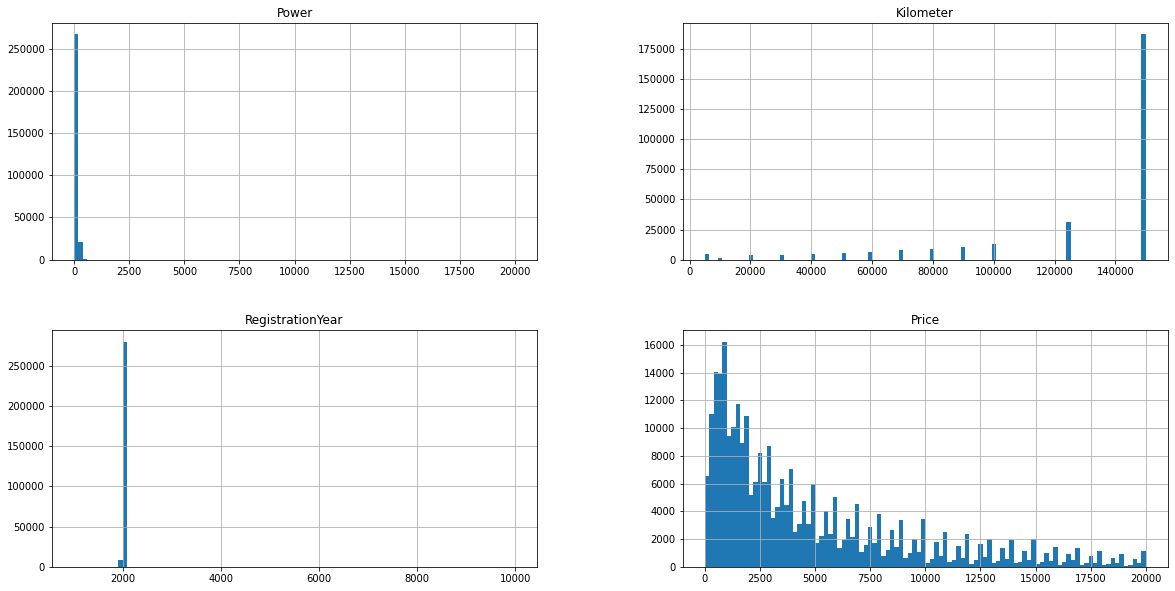

In [17]:
sorted_data.hist(figsize=(20, 10), bins=100)
plt.show()

- столбец Power, сократим данные до 2000 л.с., разброс очень большой, также есть 0, что по логике не возможно.
- столбец Kilometer, тут все хорошо, аномалий не видно. 
- столбец RegistrationYear, выбросы есть, надо обозначить интервал операясь на DateCreated (когда анкета создавалась).
- столбец Price, видим высокое стандартное отклонение, что говорит о выбросах, тут тоже выберем интервал цен следуя логики.

count    288179.000000
mean        109.587742
std          72.623382
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max        2000.000000
Name: Power, dtype: float64

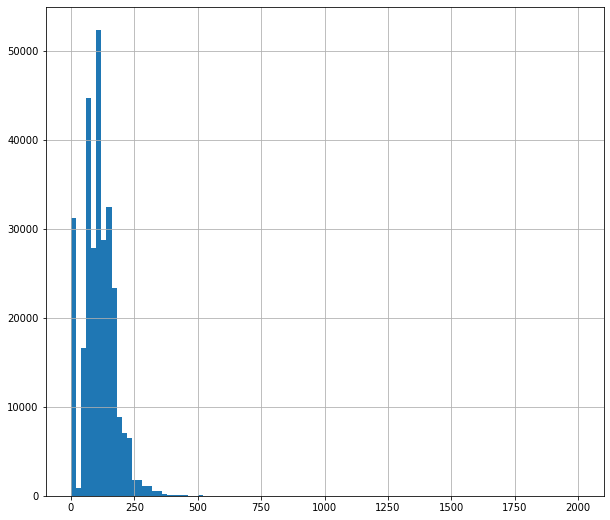

In [18]:
sorted_data = sorted_data.query('Power < 2001')
sorted_data['Power'].hist(bins=100, figsize=(10,9))
sorted_data['Power'].describe()

Судя по грфику нам надо заключить Power в интервал от 0 < Power < 550 

In [19]:
sorted_data = sorted_data.query('0 < Power < 551')

Год регистрации автомобиля заключим в промежуток от 1900 года до 2016 года.

In [20]:
date_time = pd.to_datetime(data['DateCreated'])
date_time.max()

Timestamp('2016-04-07 00:00:00')

count    247889.000000
mean       2002.923966
std           6.732142
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

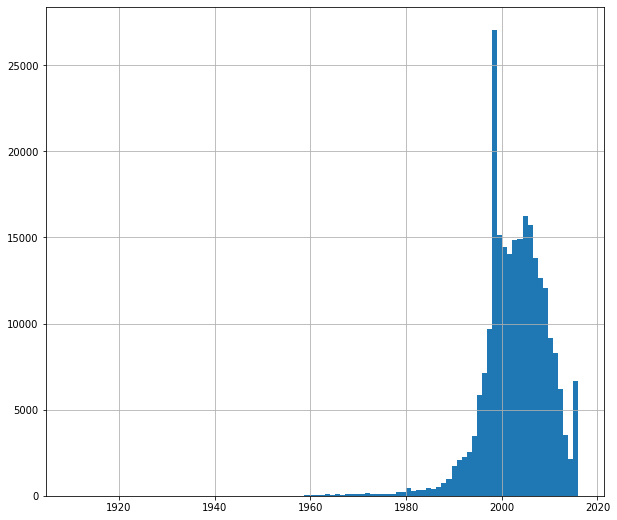

In [21]:
sorted_data = sorted_data.query('1899 < RegistrationYear < 2017')
sorted_data['RegistrationYear'].hist(bins=100, figsize=(10,9))
sorted_data['RegistrationYear'].describe()

Судя по графику, видно что есть машины на ходу с 1960 года, тогда включим эти машины.

In [22]:
sorted_data = sorted_data.query('1959 < RegistrationYear < 2017')

count    247745.000000
mean       5019.285071
std        4684.772741
min           2.000000
25%        1400.000000
50%        3390.000000
75%        7299.000000
max       20000.000000
Name: Price, dtype: float64

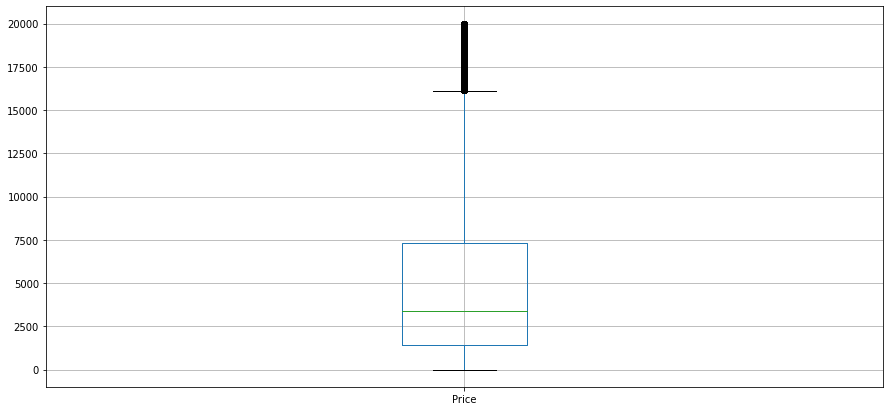

In [23]:
sorted_data.boxplot(column='Price', figsize=(15,7))
sorted_data['Price'].describe()

count    247243.000000
mean       5029.357385
std        4684.184818
min         100.000000
25%        1449.000000
50%        3400.000000
75%        7300.000000
max       20000.000000
Name: Price, dtype: float64

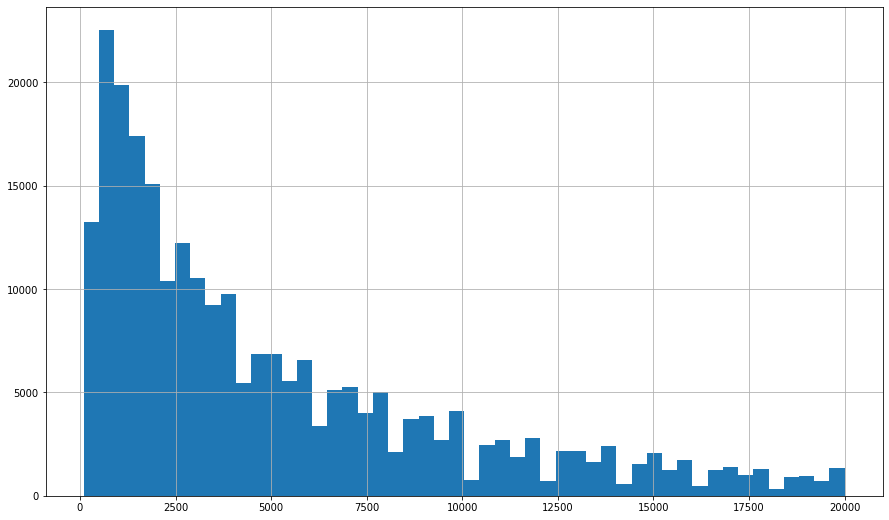

In [24]:
sorted_data = sorted_data.query('Price >= 100')
sorted_data['Price'].hist(bins=50, figsize=(15,9))
sorted_data['Price'].describe()

Рассуждая логично я заключила Price в промежуток от 200 до 7500 евро.

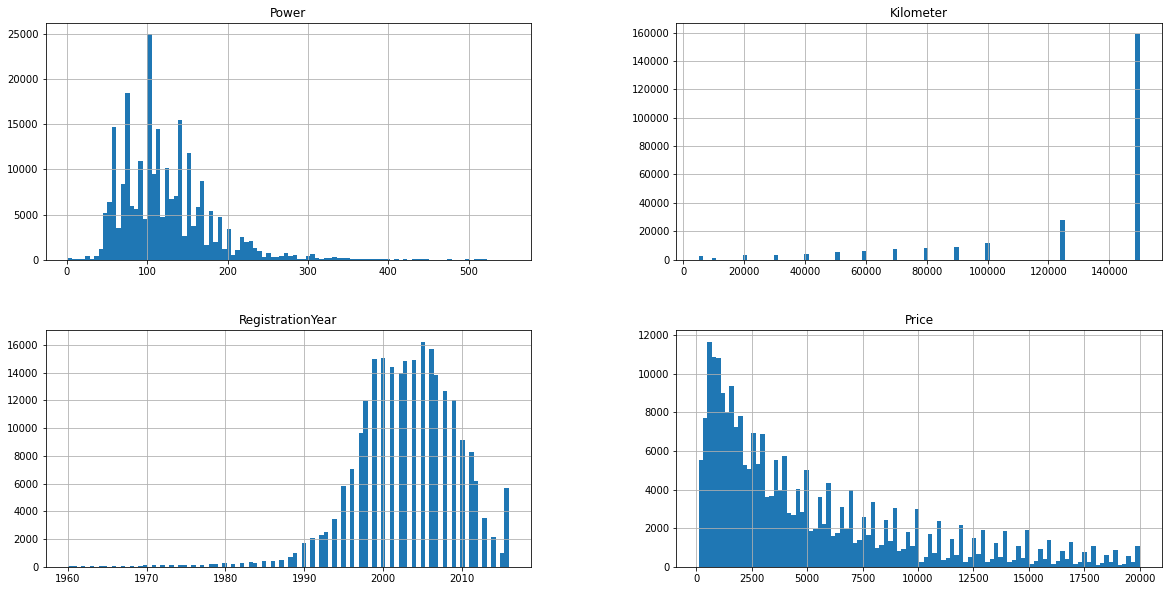

In [25]:
sorted_data.hist(figsize=(20, 10), bins=100)
plt.show()

In [26]:
sorted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247243 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       247243 non-null  object
 1   Gearbox           247243 non-null  object
 2   Power             247243 non-null  int64 
 3   Kilometer         247243 non-null  int64 
 4   FuelType          247243 non-null  object
 5   Brand             247243 non-null  object
 6   Repaired          247243 non-null  object
 7   RegistrationYear  247243 non-null  int64 
 8   Model             247243 non-null  object
 9   Price             247243 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.7+ MB


In [27]:
sorted_data = sorted_data.reset_index(drop=True)
display(sorted_data)

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model,Price
0,coupe,manual,190,125000,gasoline,audi,yes,2011,unknown,18300
1,suv,auto,163,125000,gasoline,jeep,no,2004,grand,9800
2,small,manual,75,150000,petrol,volkswagen,no,2001,golf,1500
3,small,manual,69,90000,gasoline,skoda,no,2008,fabia,3600
4,sedan,manual,102,150000,petrol,bmw,yes,1995,3er,650
...,...,...,...,...,...,...,...,...,...,...
247238,sedan,auto,150,150000,petrol,alfa_romeo,no,2016,159,5250
247239,sedan,manual,225,150000,petrol,seat,yes,2004,leon,3200
247240,convertible,auto,101,125000,petrol,smart,no,2000,fortwo,1199
247241,bus,manual,102,150000,gasoline,volkswagen,no,1996,transporter,9200


In [28]:
sorted_data['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [29]:
sorted_data['Repaired'].unique()

array(['yes', 'no'], dtype=object)

Можно заменить у столбцов Gearbox и Repaired тип данных с object на bool. Тогда у Gearbox(тип коробки передач): 1(manual) - механическая коробка передач, 0(auto) - автоматическая. У Repaired(была машина в ремонте или нет): 1(yes) - машина была в ремонте, 0(no) - не была в ремонте. Для этого создадим два новых столбца ManualGearbox и NotRepaired. 

In [30]:
sorted_data['ManualGearbox'] = 0
sorted_data.loc[sorted_data['Gearbox'] == 'manual', 'ManualGearbox'] = 1

display(sorted_data['ManualGearbox'].value_counts())
sorted_data['Gearbox'].value_counts()

1    195905
0     51338
Name: ManualGearbox, dtype: int64

manual    195905
auto       51338
Name: Gearbox, dtype: int64

In [31]:
sorted_data['NotRepaired'] = 0
sorted_data.loc[sorted_data['Repaired'] == 'yes', 'NotRepaired'] = 1

display(sorted_data['NotRepaired'].value_counts())
sorted_data['NotRepaired'].value_counts()

0    221101
1     26142
Name: NotRepaired, dtype: int64

0    221101
1     26142
Name: NotRepaired, dtype: int64

In [32]:
sorted_data.drop(['Repaired','Gearbox'], inplace=True, axis=1)
display(sorted_data)

,VehicleType,Power,Kilometer,FuelType,Brand,RegistrationYear,Model,Price,ManualGearbox,NotRepaired
0,coupe,190,125000,gasoline,audi,2011,unknown,18300,1,1
1,suv,163,125000,gasoline,jeep,2004,grand,9800,0,0
2,small,75,150000,petrol,volkswagen,2001,golf,1500,1,0
3,small,69,90000,gasoline,skoda,2008,fabia,3600,1,0
4,sedan,102,150000,petrol,bmw,1995,3er,650,1,1
...,...,...,...,...,...,...,...,...,...,...
247238,sedan,150,150000,petrol,alfa_romeo,2016,159,5250,0,0
247239,sedan,225,150000,petrol,seat,2004,leon,3200,1,1
247240,convertible,101,125000,petrol,smart,2000,fortwo,1199,0,0
247241,bus,102,150000,gasoline,volkswagen,1996,transporter,9200,1,0


Далее применим OrdinalEncoder (для деревянных моделей), One-Hot Encoding (для линейных модели и деревянных), чтобы преобразовать категориальные признаки. Для этого создадим три отдельных типа признаков. 

In [34]:
# Признаки без изменений 
features = sorted_data.drop('Price', axis=1)

# Целевой признак 
target = sorted_data['Price']

# Разделение на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)


In [35]:
#OHE - прямое кодирование
features_ohe = pd.get_dummies(features, drop_first=True)

In [36]:
features_ohe_train, features_ohe_test, target_train, target_test = train_test_split(
    features_ohe, target, test_size=0.25, random_state=12345)

In [37]:
print(features_train.shape)
print(features_test.shape)

(185432, 9)
(61811, 9)


In [38]:
print(features_ohe_test.shape)
print(features_ohe_train.shape)
print(features_ohe.shape)

(61811, 306)
(185432, 306)
(247243, 306)


In [41]:
ordinal_features_train = features_train.copy()
ordinal_features_test = features_test.copy()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder_columns = ['VehicleType','FuelType','Brand','Model']
encoder.fit(features_train[encoder_columns])

ordinal_features_train[encoder_columns] = encoder.transform(ordinal_features_train[encoder_columns])
ordinal_features_test[encoder_columns] = encoder.transform(ordinal_features_test[encoder_columns])

In [42]:
print(ordinal_features_train.shape)
print(ordinal_features_test.shape)

(185432, 9)
(61811, 9)


In [43]:
display(ordinal_features_train)

,VehicleType,Power,Kilometer,FuelType,Brand,RegistrationYear,Model,ManualGearbox,NotRepaired
242734,4.0,55,150000,6.0,24.0,2016,42.0,1,1
52399,7.0,110,150000,6.0,38.0,2002,116.0,1,0
116865,4.0,75,5000,6.0,10.0,2016,102.0,1,0
235477,2.0,190,150000,2.0,1.0,2010,30.0,0,0
193704,7.0,116,150000,6.0,38.0,2001,170.0,1,0
...,...,...,...,...,...,...,...,...,...
85412,5.0,58,125000,6.0,27.0,1999,225.0,1,0
133249,7.0,231,150000,6.0,2.0,2004,11.0,1,0
130333,5.0,60,150000,6.0,38.0,2011,107.0,1,0
77285,7.0,193,150000,2.0,2.0,2002,15.0,0,0


## Обучение моделей

Возьмем такие модели:  
- Линейная регрессия (LinearRegression)
- Дерево регрессии (DecisionTreeRegressor)  
- LightGBM Regressor 
- CatBoostRegressor

**Линейная регрессия**

In [44]:
%%time

#без масштабирования признаков
LR = LinearRegression()
#model.fit(features_ohe_train, target_train)
LR_scores = cross_val_score(LR, features_ohe_train, target_train, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)
LR_final_score = np.mean(np.sqrt(np.abs(LR_scores)))
print('RMSE логистической регресси =', LR_final_score)

RMSE логистической регресси = 2682.7951718831728
CPU times: user 47.8 s, sys: 18.9 s, total: 1min 6s
Wall time: 1min 6s


In [45]:
%%time

#Промасштабируем признаки
scaler_train = StandardScaler()
scaler_train.fit(features_ohe_train)
features_ohe_train_scale = scaler_train.transform(features_ohe_train)

LR_scores = cross_val_score(LR, features_ohe_train_scale, target_train, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)
LR_final_score_scale = np.mean(np.sqrt(np.abs(LR_scores)))
print('RMSE логистической регресси, с масштабируемыми признаками =', LR_final_score_scale)

RMSE логистической регресси, с масштабируемыми признаками = 25142766.194575302
CPU times: user 52 s, sys: 19.1 s, total: 1min 11s
Wall time: 1min 11s


Выходит, что при масштабировании признаков метрика RMSE ухудшилась, значит такой метод нам не подходит. 

**Дерево регрессии**

Здесь попробуем проверить модели на OE и OHE преобразованных признаках. 

In [46]:
%%time

#OHE
 
#подберем лучшую модель используя GridSearchCV
model = DecisionTreeRegressor(random_state=12345)
param = [{'max_depth': range(1,31)}]
grid = GridSearchCV(model, param, cv=5, scoring='neg_mean_squared_error')
grid.fit(features_ohe_train, target_train) 
print(grid.best_params_)

{'max_depth': 16}
CPU times: user 7min 37s, sys: 33.5 s, total: 8min 11s
Wall time: 8min 11s


In [47]:
%%time
model = DecisionTreeRegressor(random_state=12345, max_depth = 15)
#model.fit(features_ohe_train, target_train)
DT_scores = cross_val_score(model, features_ohe_train, target_train, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)
DT_final_score_OHE = np.mean(np.sqrt(np.abs(DT_scores)))
print('RMSE дерева регрессии OHE =', DT_final_score_OHE)

RMSE дерева регрессии OHE = 1924.3483787481232
CPU times: user 17.1 s, sys: 1.1 s, total: 18.2 s
Wall time: 18.2 s


In [48]:
%%time

#OE

#подберем лучшую модель используя GridSearchCV
DT = DecisionTreeRegressor(random_state=12345)
param = [{'max_depth': range(1,31)}]
grid = GridSearchCV(DT, param, cv=5, scoring='neg_mean_squared_error')
grid.fit(ordinal_features_train, target_train) 
print(grid.best_params_)

{'max_depth': 14}
CPU times: user 56.5 s, sys: 317 ms, total: 56.8 s
Wall time: 56.8 s


In [49]:
%%time
DT = DecisionTreeRegressor(random_state=12345, max_depth = 14)
DT_scores = cross_val_score(DT, ordinal_features_train, target_train, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)
DT_final_score_OE = np.mean(np.sqrt(np.abs(DT_scores)))
print('RMSE дерева регрессии OE =', DT_final_score_OE)

RMSE дерева регрессии OE = 1940.7305307954339
CPU times: user 1.87 s, sys: 33.7 ms, total: 1.9 s
Wall time: 1.91 s


Для дерева регрессии, у которого признаки закодированны прямым кодированием, RMSE равно 1083, а у другого дерева, для которого применили порядковое кодирование, метрика RMSE равно 1089, результаты похожи.

**LightGBM Regressor**

In [50]:
%%time
LGBM = LGBMRegressor(random_state=12343, max_depth= 4, learning_rate= 0.5 , num_leaves= 31)
LGBM_scores = cross_val_score(LGBM, ordinal_features_train, target_train, scoring='neg_mean_squared_error', n_jobs = -1)
LGMB_final_score = np.mean(np.sqrt(np.abs(LGBM_scores)))
print('RMSE LightGBM =', LGMB_final_score)

RMSE LightGBM = 1721.6125200644383
CPU times: user 14.2 s, sys: 0 ns, total: 14.2 s
Wall time: 14.3 s


**CatBoostRegressor**

In [51]:
%%time
CBR = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12343, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 

CBR_scores = cross_val_score(CBR,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                n_jobs = -1)

CBR_final_score = np.mean(np.sqrt(np.abs(CBR_scores)))
print('RMSE CatBoostRegressor =', CBR_final_score)



RMSE CatBoostRegressor = 1654.762434302795
CPU times: user 1min 49s, sys: 988 ms, total: 1min 50s
Wall time: 1min 53s


## Анализ моделей

Проанализируйте время обучения, время предсказания и качество моделей. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

**Линейная регрессия**

In [52]:
%%time
model = LinearRegression()
model.fit(features_ohe_train, target_train)

CPU times: user 13.2 s, sys: 8.22 s, total: 21.5 s
Wall time: 21.7 s


LinearRegression()

In [53]:
%%time
target_predict = model.predict(features_ohe_train)

CPU times: user 274 ms, sys: 279 ms, total: 553 ms
Wall time: 590 ms


In [54]:
%%time
final_LR = mean_squared_error(target_train, target_predict) ** 0.5
print('RMSE на train логстической регрессии =', final_LR)

RMSE на тестовой выборке логстической регрессии = 2676.698104143083
CPU times: user 16.9 ms, sys: 1.82 ms, total: 18.7 ms
Wall time: 2.59 ms


**Дерево регресии**

In [55]:
%%time
model = DecisionTreeRegressor()
param = [{'max_depth': [14]}]
grid = GridSearchCV(model, param, cv=5)
grid.fit(ordinal_features_train, target_train)
target_predict = grid.predict(ordinal_features_train)
final_DT = mean_squared_error(target_train, target_predict) ** 0.5
print('RMSE дерева регрессий на train =', final_DT)
grid.cv_results_

RMSE дерева регрессий на тесте = 1503.2841130744148
CPU times: user 2.39 s, sys: 11.1 ms, total: 2.4 s
Wall time: 2.41 s


{'mean_fit_time': array([0.3697041]),
 'std_fit_time': array([0.01331478]),
 'mean_score_time': array([0.00996099]),
 'std_score_time': array([0.00065298]),
 'param_max_depth': masked_array(data=[14],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 14}],
 'split0_test_score': array([0.83095258]),
 'split1_test_score': array([0.82862214]),
 'split2_test_score': array([0.83083553]),
 'split3_test_score': array([0.8271673]),
 'split4_test_score': array([0.82437044]),
 'mean_test_score': array([0.8283896]),
 'std_test_score': array([0.00245981]),
 'rank_test_score': array([1], dtype=int32)}

**LightGBM Regressor**

In [58]:
%%time
model = LGBMRegressor()
param = [{'max_depth': [4], 'learning_rate': [0.5], 'num_leaves':[31]}]
grid = GridSearchCV(model, param, cv=3)
grid.fit(ordinal_features_train, target_train)
target_predict = grid.predict(ordinal_features_train)
final_LGBMR = mean_squared_error(target_train, target_predict) ** 0.5
print('RMSE LightGBM регрессора на train =', final_LGBMR)
grid.cv_results_

RMSE LightGBM регрессора на тесте = 1672.2848879155927
CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 11.4 s


{'mean_fit_time': array([2.01925937]),
 'std_fit_time': array([0.13398129]),
 'mean_score_time': array([0.40486519]),
 'std_score_time': array([0.00490475]),
 'param_learning_rate': masked_array(data=[0.5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_num_leaves': masked_array(data=[31],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.5, 'max_depth': 4, 'num_leaves': 31}],
 'split0_test_score': array([0.86478793]),
 'split1_test_score': array([0.86682796]),
 'split2_test_score': array([0.8633229]),
 'mean_test_score': array([0.8649796]),
 'std_test_score': array([0.00143734]),
 'rank_test_score': array([1], dtype=int32)}

**CatBoostRegressor**

In [59]:
%%time
model = CatBoostRegressor()
param = [{'learning_rate': [0.5], 'iterations':[200]}]
grid = GridSearchCV(model, param, cv=5)
grid.fit(ordinal_features_train, target_train)
target_predict = grid.predict(ordinal_features_train)
final_CBR = mean_squared_error(target_train, target_predict) ** 0.5
print('RMSE дерева регрессий на train =', final_CBR)
grid.cv_results_

0:	learn: 3353.7375506	total: 19ms	remaining: 3.79s
1:	learn: 2711.7631278	total: 39.4ms	remaining: 3.9s
2:	learn: 2424.9271684	total: 60.8ms	remaining: 3.99s
3:	learn: 2269.3546326	total: 79.7ms	remaining: 3.91s
4:	learn: 2171.0443147	total: 98.4ms	remaining: 3.84s
5:	learn: 2118.7804150	total: 117ms	remaining: 3.79s
6:	learn: 2080.6968114	total: 135ms	remaining: 3.73s
7:	learn: 2054.3037131	total: 153ms	remaining: 3.68s
8:	learn: 1991.2677297	total: 175ms	remaining: 3.71s
9:	learn: 1966.9220748	total: 196ms	remaining: 3.73s
10:	learn: 1950.1547809	total: 216ms	remaining: 3.71s
11:	learn: 1933.7295530	total: 234ms	remaining: 3.67s
12:	learn: 1921.4791548	total: 253ms	remaining: 3.63s
13:	learn: 1909.3757461	total: 271ms	remaining: 3.6s
14:	learn: 1892.7243241	total: 295ms	remaining: 3.63s
15:	learn: 1884.8506981	total: 312ms	remaining: 3.59s
16:	learn: 1874.7076747	total: 331ms	remaining: 3.56s
17:	learn: 1864.8853909	total: 349ms	remaining: 3.53s
18:	learn: 1858.2029502	total: 367ms	

{'mean_fit_time': array([4.99451365]),
 'std_fit_time': array([0.46676802]),
 'mean_score_time': array([0.01405001]),
 'std_score_time': array([0.00335892]),
 'param_iterations': masked_array(data=[200],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'iterations': 200, 'learning_rate': 0.5}],
 'split0_test_score': array([0.87418886]),
 'split1_test_score': array([0.87714962]),
 'split2_test_score': array([0.87542726]),
 'split3_test_score': array([0.87565373]),
 'split4_test_score': array([0.86912357]),
 'mean_test_score': array([0.87430861]),
 'std_test_score': array([0.00275793]),
 'rank_test_score': array([1], dtype=int32)}

**Вывод:** Время обучения линейной регрессии равно 21с, скорость предсказаний 590 мс, качество модели (RMSE) 2676.  
Время обучения дерева регрессии равно 4мс (в cv_results_ указан [0.36]), скорость предсказаний [0.009] в cv_results_ указано (без понятия секунды это или милисекунды или еще меньше число), качество модели (RMSE) 1503.  
Время обучения LightGBM регрессора равно 2с ([2.01]), скорость предсказаний 4 мс [0.4], качество модели (RMSE) 1672.   
Время обучения CatBoostRegressor равно 5с ([4.99]), скорость предсказаний 1мс [0.01], качесвто модели (RMSE) 1568.


Выходит нам подходит три модели дерева регрессии, LightGBM регрессор, CatBoostRegressor. Я выберу LightGBM Regressor. 

Обучение на тесте одной лучшей модели:

In [60]:
%%time
model = LGBMRegressor()
model.fit(ordinal_features_train, target_train)

CPU times: user 4.83 s, sys: 0 ns, total: 4.83 s
Wall time: 4.77 s


LGBMRegressor()

In [62]:
%%time
predict = model.predict(ordinal_features_test)

CPU times: user 532 ms, sys: 0 ns, total: 532 ms
Wall time: 507 ms


In [63]:
%%time
final_LGBM = mean_squared_error(target_test, predict) ** 0.5
print('RMSE на тестовой выборке LGBMRegressor =', final_LGBM)

RMSE на тестовой выборке LGBMRegressor = 1729.619377074739
CPU times: user 2.48 ms, sys: 0 ns, total: 2.48 ms
Wall time: 1.41 ms
